<a href="https://colab.research.google.com/github/krisrjohnson/TFCoursework/blob/master/Course_1_Part_6_Lesson_2_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Improving Computer Vision Accuracy using Convolutions

In the previous lessons you saw how to do fashion recognition using a Deep Neural Network (DNN) containing three layers -- the input layer (in the shape of the data), the output layer (in the shape of the desired output) and a hidden layer. You experimented with the impact of different sized of hidden layer, number of training epochs etc on the final accuracy.

For convenience, here's the entire code again. Run it and take a note of the test accuracy that is printed out at the end. 

In [0]:
#this is the basic single hidden neuron Deep Neural Network
import tensorflow as tf
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data() #load data
training_images, test_images=training_images / 255.0, test_images/255.0 # normalize data (range is now 0:1)

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(training_images, training_labels, epochs=5)

test_loss = model.evaluate(test_images, test_labels)

4423680/4422102 [==============================] - 0s 0us/step
Instructions for updating:
Colocations handled automatically by placer.
Epoch 1/5
60000/60000 [==============================] - 8s 130us/sample - loss: 0.4984 - acc: 0.8241
Epoch 2/5
60000/60000 [==============================] - 7s 117us/sample - loss: 0.3743 - acc: 0.8656
Epoch 3/5
60000/60000 [==============================] - 7s 115us/sample - loss: 0.3378 - acc: 0.8759
Epoch 4/5
60000/60000 [==============================] - 7s 115us/sample - loss: 0.3117 - acc: 0.8856
Epoch 5/5
10000/10000 [==============================] - 1s 74us/sample - loss: 0.3603 - acc: 0.8722


Your accuracy is probably about 89% on training and 87% on validation...not bad...But how do you make that even better? One way is to use something called Convolutions. I'm not going to details on Convolutions here, but the ultimate concept is that they narrow down the content of the image to focus on specific, distinct, details. 

If you've ever done image processing using a filter (like this: https://en.wikipedia.org/wiki/Kernel_(image_processing)) then convolutions will look very familiar.

In short, you take an array (usually 3x3 or 5x5) and pass it over the image. By changing the underlying pixels based on the formula within that matrix, you can do things like edge detection. So, for example, if you look at the above link, you'll see a 3x3 that is defined for edge detection where the middle cell is 8, and all of its neighbors are -1. In this case, for each pixel, you would multiply its value by 8, then subtract the value of each neighbor. Do this for every pixel, and you'll end up with a new image that has the edges enhanced.

This is perfect for computer vision, because often it's features that can get highlighted like this that distinguish one item for another, and the amount of information needed is then much less...because you'll just train on the highlighted features.

That's the concept of Convolutional Neural Networks. Add some layers to do convolution before you have the dense layers, and then the information going to the dense layers is more focussed, and possibly more accurate.

Run the below code -- this is the same neural network as earlier, but this time with Convolutional layers added first. It will take longer, but look at the impact on the accuracy:

In [11]:
(test_loss, test_acc) = model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 98us/sample - loss: 0.4462 - acc: 0.9133


It's likely gone up to about 93% on the training data and 91% on the validation data. 

That's significant, and a step in the right direction!

Try running it for more epochs -- say about 20, and explore the results! But while the results might seem really good, the validation results may actually go down, due to something called 'overfitting' which will be discussed later. 

(In a nutshell, 'overfitting' occurs when the network learns the data from the training set really well, but it's too specialised to only that data, and as a result is less effective at seeing *other* data. For example, if all your life you only saw red shoes, then when you see a red shoe you would be very good at identifying it, but blue suade shoes might confuse you...and you know you should never mess with my blue suede shoes.)

Then, look at the code again, and see, step by step how the Convolutions were built:

Step 1 is to gather the data. You'll notice that there's a bit of a change here in that the training data needed to be reshaped. That's because the first convolution expects a single tensor containing everything, so instead of 60,000 28x28x1 items in a list, we have a single 4D list that is 60,000x28x28x1, and the same for the test images. If you don't do this, you'll get an error when training as the Convolutions do not recognize the shape. 



```
import tensorflow as tf
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images=training_images.reshape(60000, 28, 28, 1)
training_images=training_images / 255.0
test_images = test_images.reshape(10000, 28, 28, 1)
test_images=test_images/255.0
```



Next is to define your model. Now instead of the input layer at the top, you're going to add a Convolution. The parameters are:

1. The number of convolutions you want to generate. Purely arbitrary, but good to start with something in the order of 32
2. The size of the Convolution, in this case a 3x3 grid
3. The activation function to use -- in this case we'll use relu, which you might recall is the equivalent of returning x when x>0, else returning 0
4. In the first layer, the shape of the input data.

You'll follow the Convolution with a MaxPooling layer which is then designed to compress the image, while maintaining the content of the features that were highlighted by the convolution. By specifying (2,2) for the MaxPooling, the effect is to quarter the size of the image. Without going into too much detail here, the idea is that it creates a 2x2 array of pixels, and picks the biggest one, thus turning 4 pixels into 1. It repeats this across the image, and in so doing halves the number of horizontal, and halves the number of vertical pixels, effectively reducing the image by 25%.

You can call model.summary() to see the size and shape of the network, and you'll notice that after every MaxPooling layer, the image size is reduced in this way. 


```
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
```



Add another convolution



```
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2)
```



Now flatten the output. After this you'll just have the same DNN structure as the non convolutional version

```
  tf.keras.layers.Flatten(),
```



The same 128 dense layers, and 10 output layers as in the pre-convolution example:



```
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
```



Now compile the model, call the fit method to do the training, and evaluate the loss and accuracy from the test set.



```
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(training_images, training_labels, epochs=5)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)
```




# Visualizing the Convolutions and Pooling

This code will show us the convolutions graphically. The print (test_labels[;100]) shows us the first 100 labels in the test set, and you can see that the ones at index 0, index 23 and index 28 are all the same value (9). They're all shoes. Let's take a look at the result of running the convolution on each, and you'll begin to see common features between them emerge. Now, when the DNN is training on that data, it's working with a lot less, and it's perhaps finding a commonality between shoes based on this convolution/pooling combination.

In [70]:
import matplotlib.pyplot as plt
import numpy as np

label_num = 3
print(test_labels[:100])

first_100_same = []
for i in range(100):
  if (test_labels[i]==label_num):
    first_100_same.append(i)
    #print (i)

FIRST_IMAGE=first_100_same[0]
SECOND_IMAGE=first_100_same[1]
THIRD_IMAGE=first_100_same[2]
#np.squeeze(test_images[FIRST_IMAGE]).shape

[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 6 1 3 7 6 7 2 1 2 2 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 2 3 9 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 4 2]


In [105]:
import tensorflow as tf
print(tf.__version__)

#data loading and reshaping
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images=training_images.reshape(60000, 28, 28, 1)
training_images=training_images / 255.0
test_images = test_images.reshape(10000, 28, 28, 1)
test_images=test_images/255.0

#model compilation and fit
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
model.fit(training_images, training_labels, epochs=20)

#basic model evaluation
(test_loss, test_acc) = model.evaluate(test_images, test_labels)


1.13.1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               204928    
_________________________________________________________________
dense_35 (Dense)             (None, 10)                1290      
Tot

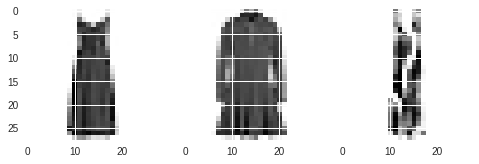

In [71]:
#test_images = test_images.reshape(10000, 28, 28, 1)
#plt.imshow(np.squeeze(test_images[FIRST_IMAGE]))

fig, axis = plt.subplots(1,3)

axis[0].imshow(np.squeeze(test_images[FIRST_IMAGE])) #using squeeze to get rid of the 1 in (28, 28, 1) shape
axis[0].label_outer()
axis[1].imshow(np.squeeze(test_images[SECOND_IMAGE])) #which is a color scale indicator (3 would be RGB)
axis[1].label_outer()
axis[2].imshow(np.squeeze(test_images[THIRD_IMAGE]))
axis[2].label_outer()

plt.show()

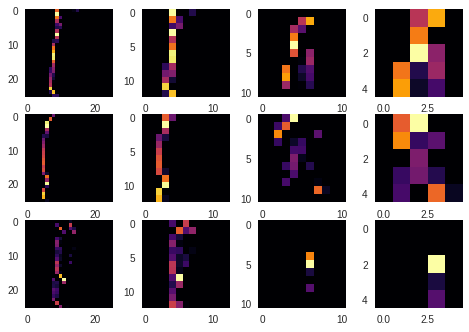

In [76]:

CONVOLUTION_NUMBER = 1

#new plot figure, f, with axis array, axarr:
f, axarr = plt.subplots(3,4)

from tensorflow.keras import models

#extracting the different layers of the model to be able to visualize all 4 layers (0:CNN,1:Pool,2:CNN,3:Pool)
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)

for x in range(4): #iterate over the first 4 layers #edited range(0,4) to range(4), same thing
  f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[0,x].grid(False)
  f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[1,x].grid(False)
  f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[2,x].grid(False)

Displaying all convolutions

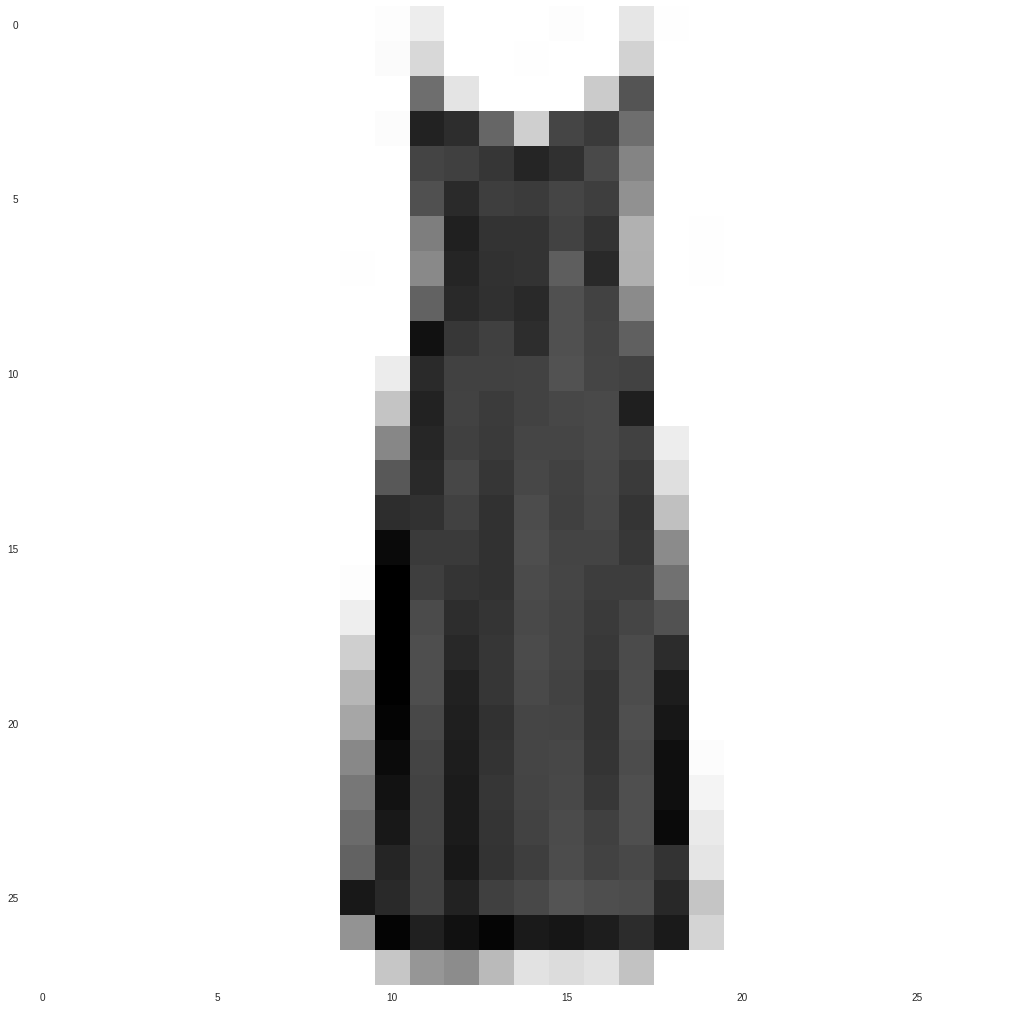

In [116]:
#original image

plt.grid(False)
plt.rcParams["figure.figsize"] = [3,4] 
plt.imshow(np.squeeze(test_images[FIRST_IMAGE]))


In [104]:
convolutions = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[0].shape[3]
print (convolutions)

64


8 8


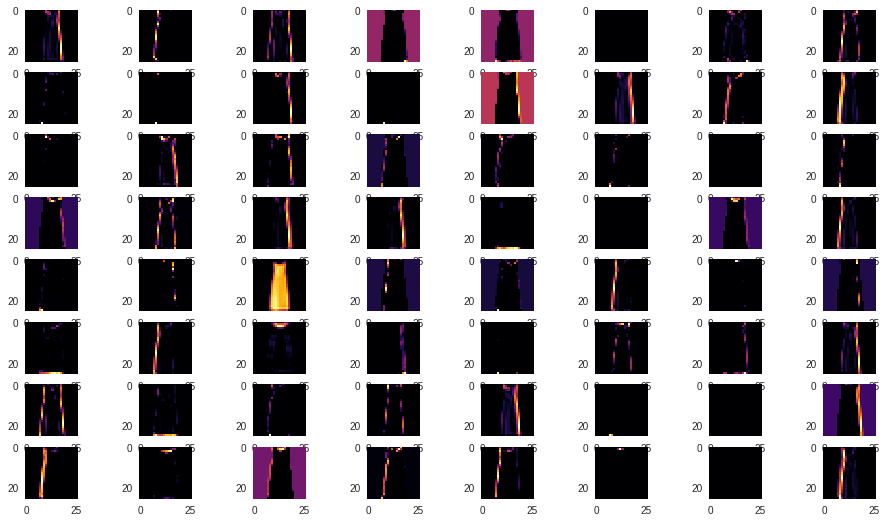

In [113]:
#TODO: redefine this plt as a fn to easily pass in model and img_num

#the first convolutions, iterating over CONVOLUTION_NUMBER from example above
#new plot figure, f, with axis array, axarr:
#convolutions are powers of 2 (not universally true, but for this workbook yes)
Nr = int(convolutions ** .5)
Nc = int(convolutions / Nr) #so if 32, it'll be 5x7
if(convolutions % Nr != 0): Nc+=1
f, axarr = plt.subplots(Nr, Nc)


#from tensorflow.keras import models

#extracting the different layers of the model to be able to visualize all 4 layers (0:CNN,1:Pool,2:CNN,3:Pool)
#layer_outputs = [layer.output for layer in model.layers]
#activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)


plt.rcParams["figure.figsize"] = [32,18] 
#for x in range(convolutions): #iterate over the first 4 layers #edited range(0,4) to range(4), same thing
for x in range(Nr):
  for y in range(Nc):
    f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[0]
    axarr[x,y].imshow(f1[0, : , :, x*Nc+y], cmap='inferno') #believe there are 64 here
    axarr[x,y].grid(False)

plt.show()

EXERCISES

1. Try editing the convolutions. Change the 32s to either 16 or 64. What impact will this have on accuracy and/or training time.
  
  **A: Before change**, assume fewer convolutions will mean faster and less accurate and vice versa.
      **After change**: Going w/ 16 vs the original 64 (despite the questions assertion it was 32) makes it go slightly faster and definitely less accurate (epoch 11 accuracy on training data is .931 w/ 16 vs .966 w/ 64). The end result is lower loss (yay) but lower accuracy (.9 vs .91) on the validation data.

2. Remove the final Convolution. What impact will this have on accuracy or training time?
  
  **A:** I'm assuming the 2nd pool is considered the final convolution. Removing it means the data for the Deep Neural Network (DNN) will be 4x larger, so I'd expect runtime to drastically increase. However, the end result might be more accurate since we're removing some data loss from pooling. Also, from the investigatory images above of the different convolutions, the fourth layer might be too abstract, so removing it could also benefit accuracy.
  **After Running**: Accuracy was lower than 4 convolutions and 64 convolutions (in the conv2d convolutions). Loss higher than both previous models.

3. How about adding more Convolutions? What impact do you think this will have? Experiment with it.
  
  **A:** Adding more convolutions will not necessarily improve the model. From our visualizations of a small sample of the convolution layers above, the fourth convolution (the 2nd pool) has fairly abstract data. Adding more convolutions to further identify edges or further pool data down will likely abstract too far and remove intelligible signals (the fourth pool outputs a 5x5 image! Further pooling will reduce to a single pixel!)
**After**: When upping the convolutions per conv2D I get less accuracy on training data at epoch 20 but similar accuracy on test data indicating this is a better a model and the one in Ex2 is relatively overfit. Surprised I can have such high accuracy with a 3x3 x64 input layer to the DNN

4. Remove all Convolutions but the first. What impact do you think this will have? Experiment with it. 

  **A:** Certainly processing will take longer as input to the DNN will be 64x larger at least (28x28 vs 5x5 so really 31x). It's possible a single layer of convolutions is good enough to isolate the edges necessary to have a high accuracy model since the images are so simplistic, so accuracy could potentially increase. 
  **After:** Loss is pretty high on test data, while accuracy goes from 99% for epoch 20 training data to 91% for test data indicating some overfitting. Loss is higher on test data than the first layer of training data!!!

5. In the previous lesson you implemented a callback to check on the loss function and to cancel training once it hit a certain amount. See if you can implement that here! 

  **A** Dumb mistake, didn't flip the < to > from loss to accuracy so took me awhile to implement. Otherwise fairly straightforward copypasta from last workbook

In [0]:
#data loading and reshaping
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images=training_images.reshape(60000, 28, 28, 1)
training_images=training_images / 255.0
test_images = test_images.reshape(10000, 28, 28, 1)
test_images=test_images/255.0

### Exercise 1

In [0]:
#Saving original model as model64
model64 = model

In [0]:
#import tensorflow as tf
#print(tf.__version__)

#data loading and reshaping - done above

#model compilation and fit
model16 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model16.summary()
model16.fit(training_images, training_labels, epochs=20)

#basic model evaluation
(test_loss, test_acc) = model16.evaluate(test_images, test_labels)


### Exercise 2

In [89]:
## remove the final convolution ##

#data loading and reshaping
# loaded and normalize above: training_images, training_labels, test_images, test_lables

#model compilation and fit
model_3convs = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
  #tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(), 
  tf.keras.layers.Dense(128, activation='relu'), # hidden layer
  tf.keras.layers.Dense(10, activation='softmax') # output layer (softmax basically = max)
])
model_3convs.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_3convs.summary()
model_3convs.fit(training_images, training_labels, epochs=20)

#basic model evaluation
(test_loss, test_acc) = model_3convs.evaluate(test_images, test_labels)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 11, 11, 16)        2320      
_________________________________________________________________
flatten_11 (Flatten)         (None, 1936)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               247936    
_________________________________________________________________
dense_23 (Dense)             (None, 10)                1290      
Total params: 251,706
Trainable params: 251,706
Non-trainable params: 0
_________________________________________________________________
Epoc

###Exercise 3

In [90]:
## Add more convolutions - 
  #2nd pool already outputs 5x5, so likely more conv's will result in data loss

# loaded and normalize above: training_images, training_labels, test_images, test_lables

#going back to 64 convolutions per and expanding first conv2D to 5x5 per pixel
  #so first layer will output 24x24 not 26x26
  #24x24 pooled down will be 12x12 not 13x13, then conv2D'ed will be 10x10; 
  #then pooled again, 5x5! 
  #Conv2D'ed once more: 3x3!!!!!!
model_5convs = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (5,5), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'), # is this possible on a 5x5? 
  tf.keras.layers.Flatten(), 
  tf.keras.layers.Dense(128, activation='relu'), # hidden layer
  tf.keras.layers.Dense(10, activation='softmax') # output layer (softmax basically = max)
])
model_5convs.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_5convs.summary()
model_5convs.fit(training_images, training_labels, epochs=20)

#basic model evaluation
(test_loss, test_acc) = model_5convs.evaluate(test_images, test_labels)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               73856     
__________

###Exercise 4

In [91]:
## Remove all but first!

# loaded and normalize above: training_images, training_labels, test_images, test_lables

#what'll be diff b/t 7x7, 5x5, and 3x3. 7x7 seems overkill for finding edges
model_1conv = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (5,5), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(), 
  tf.keras.layers.Dense(128, activation='relu'), # hidden layer
  tf.keras.layers.Dense(10, activation='softmax') # output layer (softmax basically = max)
])
model_1conv.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_1conv.summary()
model_1conv.fit(training_images, training_labels, epochs=20)

#basic model evaluation
(test_loss, test_acc) = model_1conv.evaluate(test_images, test_labels)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 9216)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dense_27 (Dense)             (None, 10)                1290      
Total params: 1,182,730
Trainable params: 1,182,730
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
60000/60000 [==============================] - 13s 217us/sample - loss: 0.4069 - acc: 0.8544
Epoch 2/20
60000/60000 [====

### Exercise 5

In [0]:
#code from last workbook
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')<0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),  #flatten 28x28 img into 784x1 array
    tf.keras.layers.Dense(512, activation=tf.nn.relu),  #512 worked most efficiently on fashion data, trying
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)  #softmax is basically a max fn
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=10, callbacks=[callbacks])

model.evaluate(x_test, y_test)

In [94]:
ACCURACY = 0.9
LOSS = 0.3
METRIC = "accuracy"
EPOCHS = 10

#import tensorflow as tf
#print(tf.__version__)

#data loaded and normalized above: test_images, training_images, test_labels, training_labels


class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.90):
    #if(logs.get('loss')<0.3):
      #print("\nReached " +str(ACCURACY) + "% "+METRIC+" so cancelling training!")
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True


callbacks = myCallback()
model_callback = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

model_callback.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_callback.fit(training_images, training_labels, epochs=EPOCHS, callbacks=[callbacks])

test_loss, test_acc = model_callback.evaluate(test_images, test_labels)
print(test_acc)

Epoch 1/10
59744/60000 [============================>.] - ETA: 0s - loss: 0.1421 - acc: 0.9561
Reached 90% accuracy so cancelling training!
10000/10000 [==============================] - 1s 111us/sample - loss: 0.0500 - acc: 0.9831
0.9831
